# Beat Populations

Link census tract populations, total and by race, into police beats. Attributes population from tracts to beats by the areas of the overlaps. The basic procedure is to find the overlaps between beats and Census tracts, then addign a portion of the population of the tract to the beat, based on the raio of the size of overlap to the size of the tract. 

In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

# San Diego Police Regions and Demographics
`sandiego.gov-police_regions-5` Last Update: 2019-12-19T19:26:45

_Boundary shapes for San Diego neighborhoods, beats and divisions, with ACS estimates for populations, by race._


This package links shapefiles for San Diego police beats to Census tracts and
merges in ACS estimates for population, by race, from the 2016 5 year ACS. When
a police beat boundry crosses a tract, the tract population is allocated to
beats by the proportion of the overlap by area. See the [Jupyter
notebook](https://github.com/metatab-packages/metatab-packages/blob/master/sandi
ego.gov/sandiego.gov-police_regions/notebooks/BeatPopulations.ipynb) that
performs the procedure for details.

For the race/ethicty statistics, Hispanic ('hisp') refers to Hispanics of any
race, while all other races refer to non-Hispanics of that race.
## Documentation Links

* [Police Divisions Repository Page](https://data.sandiego.gov/datasets/pd-divisions/) Data repository page that links to original files.

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [pd_beats](shape+http://seshat.datasd.org/sde/pd/pd_beats_datasd.zip)**. Police beats
* ** [pd_divisions](shape+http://seshat.datasd.org/sde/pd/pd_divisions_datasd.zip)**. Police Divisions
* ** [pd_neighborhoods](shape+http://seshat.datasd.org/sde/pd/pd_divisions_datasd.zip)**. Police Neighborhoods
* ** [beat_demographics](notebooks/BeatPopulations.ipynb#beat_demographics)**. Counts of people in the beat, by race.

## References
<ul><li> <strong>tracts</string>, <em>metapack+http://library.metatab.org/sandiegodata.org-communities-2018-7.csv#tracts</em>. Census tracts from 2016 5 year ACS, for San Diego county</li><li> <strong>race</string>, <em>census://2016/5/CA/140/B03002</em>. Race, by tract, in San Diego county</li><ul>

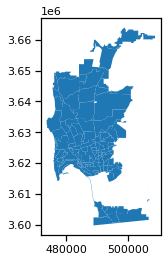

In [3]:
# Convert to EPSG:26911, ( A randomly selected UTM Zone 11N CRS) so area calculations 
# will be in square meters, rather than square degrees
beats = pkg.resource('pd_beats').geoframe().to_crs(26911)

# There are  beats that are way off in east county. Get rid of them.
rightmost_centroid = beats.centroid.x.sort_values(ascending=False).iloc[:6].max()

beats = beats[beats.centroid.x <rightmost_centroid]

# It looks like the dataset has multiple rows per beat, one feature per row. We need
# it to have one row per beat, with multiple features combined together. 
beats = beats.dissolve(by='beat').reset_index()

#  Add the area
beats['beat_area'] = beats.area / 1_000_000

beats.plot()


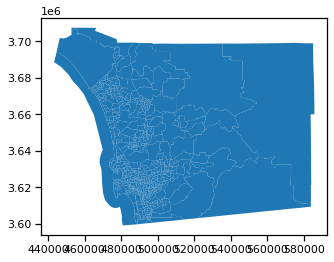

In [4]:
tracts = pkg.reference('tracts').geoframe().to_crs(26911)

#  Add the area
tracts['tract_area'] = tracts.area / 1_000_000


tracts.plot()

In [5]:
from rowgenerators import dataframe, parse_app_url
t = dataframe('census://CA/140/B03002')

In [6]:
# White, black, asian, etc are all non hispanic. 
col_map = {
    'b03002_001':'total',
    'b03002_003':'white',
    'b03002_004':'black',
    'b03002_005':'aian',
    'b03002_006':'asian',
    'b03002_007':'nhopi', 
    'b03002_012':'hisp'
    
}

for k,v in list(col_map.items()):
    col_map[k+'_m90'] = col_map[k]+'_m90'
    
race_tracts = t[t.county=='073'].rename(columns=col_map).reset_index().rename(columns={'GEOID':'geoid'})

In [7]:
race_tracts = race_tracts[['geoid', 'total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp']]
race_tracts.titles.head().T

,0,1,2,3,4
GEOID,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
total,3250,1915,4583,5094,3758
white,2492,1616,3282,3693,2321
black,0,10,40,260,188
aian,0,9,32,0,0
asian,142,41,430,111,415
nhopi,0,0,11,7,0
hisp,516,135,635,825,730


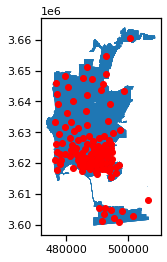

In [8]:
t = gpd.sjoin(beats, tracts)

ax = t.plot()
beats.centroid.plot(ax=ax, color='red')

t = t[['geoid', 'beat']].drop_duplicates()\
    .merge(tracts[['geoid','geometry', 'tract_area']],on='geoid')\
    .merge(beats[['beat','geometry', 'beat_area']],on='beat')


In [9]:
intr = gpd.overlay(beats, tracts, how='intersection')[['beat','geoid','geometry']]

intr['intr_area'] = (intr.geometry.area/1_000_000.0).astype(float)

# Get rid of really small intersections
intr = intr[intr.intr_area >= .01] 

merged = intr[['beat','geoid', 'intr_area']]\
    .merge(tracts[['geoid', 'tract_area']],on='geoid')\
    .merge(beats[['beat', 'beat_area']],on='beat')\
    .merge(race_tracts, on='geoid')

merged = merged.drop_duplicates(subset=['beat','geoid'])

merged['tract_overlap_proportion'] = merged.intr_area/merged.tract_area
merged['beat_overlap_proportion'] = merged.intr_area/merged.beat_area

# The intersection areas must be smaller than both of the areas being intersected
assert(not any(merged.intr_area > merged.beat_area))
assert(not any(merged.intr_area > merged.tract_area))

# Check that all of the areas of the beats are accounted for
assert(all(merged.groupby('beat').beat_overlap_proportion.sum().round(1) == 1))

merged['total'] = merged.total * merged.tract_overlap_proportion
merged['white'] = merged.white * merged.tract_overlap_proportion
merged['asian'] = merged.asian * merged.tract_overlap_proportion
merged['black'] = merged.black * merged.tract_overlap_proportion
merged['aian']  = merged.aian * merged.tract_overlap_proportion
merged['hisp']  = merged.hisp * merged.tract_overlap_proportion
merged['nhopi']  = merged.nhopi * merged.tract_overlap_proportion

merged.head().T


,0,1,2,3,4
beat,0,611,612,613,615
geoid,14000US06073021400,14000US06073021400,14000US06073021400,14000US06073021400,14000US06073021400
intr_area,0.0131968,2.06007,0.118407,0.251373,0.906558
tract_area,3.36345,3.36345,3.36345,3.36345,3.36345
beat_area,18.2475,10.1375,1.75357,4.97442,2.35392
total,28.0302,4375.62,251.497,533.918,1925.54
white,19.0569,2974.86,170.985,362.995,1309.12
black,0.863191,134.747,7.74486,16.442,59.2971
aian,0,0,0,0,0
asian,2.41693,377.293,21.6856,46.0377,166.032


In [10]:
beat_demographics = merged.groupby('beat').sum()[['total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp']].round()